# NINO를 활용한 인도양 쌍극자 지수 예측 모델
- 작성자 : 에티버스러닝

## 데이터 불러오기

In [ ]:
import missingno as msno # 결측치 시각화
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
# NetCDF 파일 열기
target = xr.open_dataset('./iod.nc', decode_times=False)
df1 = xr.open_dataset('./sst.anom.mon.mean.nc', decode_times=False)
df2 = xr.open_dataset('./precip.anom.mon.mean.nc', decode_times=False)
df3 = xr.open_dataset('./uwnd.10m.anom.mon.mean.nc', decode_times=False)
df4 = xr.open_dataset('./vwnd.10m.anom.mon.mean.nc', decode_times=False)

In [ ]:
df1

<xarray.Dataset>
Dimensions:  (time: 499, lon: 360, lat: 180)
Coordinates:
  * time     (time) float64 1.737e+07 1.737e+07 ... 1.773e+07 1.773e+07
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Fri Aug 25 15:39:59 2023: cdo -f nc import_binary sst.anom....
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [ ]:
# xarray DataArray를 Pandas DataFrame으로 변환하고 인덱스를 재설정합니다
df_target = target.to_dataframe().reset_index()
df_sst = df1.to_dataframe().reset_index()
df_precip = df2.to_dataframe().reset_index()
df_uwnd = df3.to_dataframe().reset_index()
df_vwnd = df4.to_dataframe().reset_index()

In [ ]:
df_uwnd

,time,lon,lat,lev,uwnd
0,17365128.0,0.000,-88.5420,10.0,0.299840
1,17365128.0,0.000,-86.6531,10.0,1.944643
2,17365128.0,0.000,-84.7532,10.0,2.084280
3,17365128.0,0.000,-82.8508,10.0,1.103399
4,17365128.0,0.000,-80.9473,10.0,0.171486
...,...,...,...,...,...
9005947,17728872.0,358.125,80.9473,10.0,0.310204
9005948,17728872.0,358.125,82.8508,10.0,0.387655
9005949,17728872.0,358.125,84.7532,10.0,0.596672
9005950,17728872.0,358.125,86.6531,10.0,1.241549


## 데이터 전처리

### 데이터 필터링
- 필요한 부분만 필터링 해주도록 하겠습니다.

In [ ]:
# 서인도양 필터링
df_WITO_sst = df_sst[
    (df_sst['lon'] >= 50) & (df_sst['lon'] <= 70) &
    (df_sst['lat'] >= -10) & (df_sst['lat'] <= 10)
]

# 남동인도양 필터링
df_SETIO_sst = df_sst[
    (df_sst['lon'] >= 90) & (df_sst['lon'] <= 110) &
    (df_sst['lat'] >= -10) & (df_sst['lat'] <= 0)
]

# 인도네시아 강수량 필터링
Indonesia_precip = df_precip[
    (df_precip['lon'] >= 95) & (df_precip['lon'] <= 141) &
    (df_precip['lat'] >= -11) & (df_precip['lat'] <= 6)
]

# 동아프리카 강수량 필터링
EastAfrica_precip = df_precip[
    (df_precip['lon'] >= 30) & (df_precip['lon'] <= 42) &
    (df_precip['lat'] >= -12) & (df_precip['lat'] <= 5)
]

# 인도 몬순 강수량 필터링
df_Monsoon = df_precip[
    (df_precip['lat'] >= 5) & (df_precip['lat'] <= 30) &
    (df_precip['lon'] >= 65) & (df_precip['lon'] <= 95)
]

# 서인도양 필터링
df_WITO_uwnd = df_uwnd[
    (df_uwnd['lon'] >= 50) & (df_uwnd['lon'] <= 70) &
    (df_uwnd['lat'] >= -10) & (df_uwnd['lat'] <= 10)
]

# 남동인도양 필터링
df_SETIO_uwnd = df_uwnd[
    (df_uwnd['lon'] >= 90) & (df_uwnd['lon'] <= 110) &
    (df_uwnd['lat'] >= -10) & (df_uwnd['lat'] <= 0)
]

# 서인도양 필터링
df_WITO_vwnd = df_vwnd[
    (df_vwnd['lon'] >= 50) & (df_vwnd['lon'] <= 70) &
    (df_vwnd['lat'] >= -10) & (df_vwnd['lat'] <= 10)
]

# 남동인도양 필터링
df_SETIO_vwnd = df_vwnd[
    (df_vwnd['lon'] >= 90) & (df_vwnd['lon'] <= 110) &
    (df_vwnd['lat'] >= -10) & (df_vwnd['lat'] <= 0)
]

# df_precip 필터링
df_precip_east_asia = df_precip[
    (df_precip['lat'] >= 10) & (df_precip['lat'] <= 50) &
    (df_precip['lon'] >= 100) & (df_precip['lon'] <= 160)
]

### 결측치 확인하기

In [ ]:
dataframes = [df_WITO_sst, df_SETIO_sst, Indonesia_precip, EastAfrica_precip, df_Monsoon, df_precip_east_asia,
              df_WITO_uwnd, df_SETIO_uwnd, df_WITO_vwnd, df_SETIO_vwnd]

for df in dataframes:
    print("\nDataframe info:")
    print(df.info())  # 기본 정보 출력

    # 결측치 확인
    missing_values = df.isnull().sum()
    print("\nMissing values:")
    print(missing_values)

    print("="*40)


Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 209580 entries, 9080 to 32283099
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    209580 non-null  float64
 1   lon     209580 non-null  float64
 2   lat     209580 non-null  float64
 3   sst     209081 non-null  float32
dtypes: float32(1), float64(3)
memory usage: 7.2 MB
None

Missing values:
time      0
lon       0
lat       0
sst     499
dtype: int64

Dataframe info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 104790 entries, 16280 to 32290289
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   time    104790 non-null  float64
 1   lon     104790 non-null  float64
 2   lat     104790 non-null  float64
 3   sst     97305 non-null   float32
dtypes: float32(1), float64(3)
memory usage: 3.6 MB
None

Missing values:
time       0
lon        0
lat        0
sst     7485
dtype: int64

Data

/usr/local/lib/python3.10/dist-packages/missingno/missingno.py:61: UserWarning:

Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.



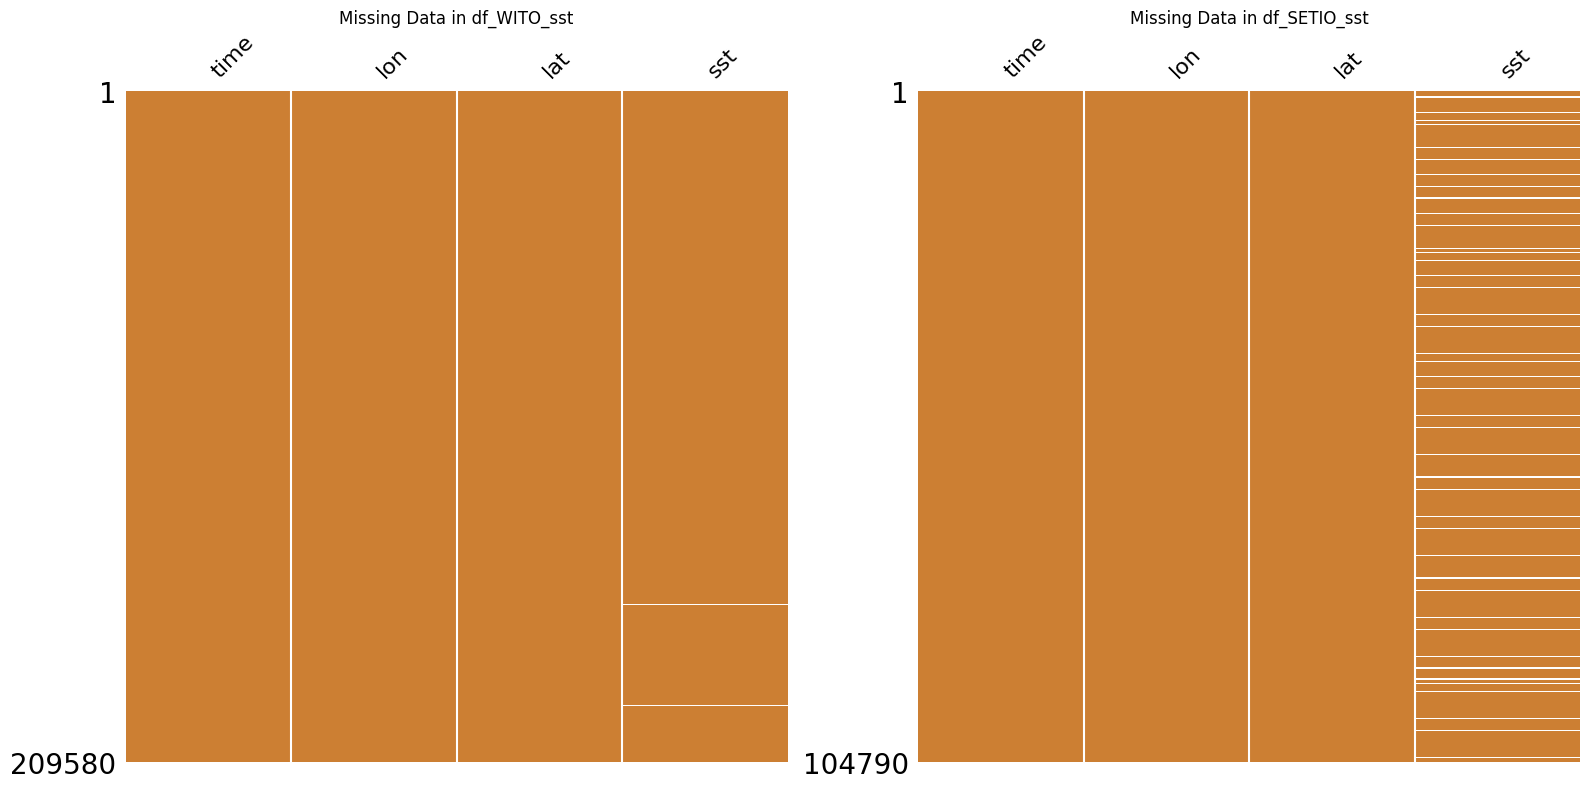

In [ ]:
# 결측치가 어디에 존재하는지 분포를 확인할 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

msno.matrix(df=df_WITO_sst, ax=ax[0], color=(0.8, 0.5, 0.2))
ax[0].set_title("Missing Data in df_WITO_sst")

msno.matrix(df=df_SETIO_sst, ax=ax[1], color=(0.8, 0.5, 0.2))
ax[1].set_title("Missing Data in df_SETIO_sst")

plt.tight_layout()
plt.show()

### 결측치 채우기
 - SST에만 결측치가 존재한다는 것을 확인하였습니다.
이제 채우도록 하겠습니다.
 - 저희는 근접하는 위경도에 데이터가 있으면 가져와서 채우는 방법을 택하였습니다. SST는 근접하는 위경도와 연속될 것이므로 이러한 방법을 택하였습니다.

In [ ]:
# 결측치 채우기 함수
def fill_missing(df_input, shift_max):
    df = df_input.copy()

    for shift_num in range(1, shift_max+1):

        df[f'sst_lat_before{shift_num}'] = df.groupby(['time', 'lon'])['sst'].shift(shift_num)
        df[f'sst_lat_after{shift_num}'] = df.groupby(['time', 'lon'])['sst'].shift(-shift_num)
        df[f'sst_lon_before{shift_num}'] = df.groupby(['time', 'lat'])['sst'].shift(shift_num)
        df[f'sst_lon_after{shift_num}'] = df.groupby(['time', 'lat'])['sst'].shift(-shift_num)

        df['sst'].fillna(df[f'sst_lat_before{shift_num}'], inplace=True)
        df['sst'].fillna(df[f'sst_lat_after{shift_num}'], inplace=True)
        df['sst'].fillna(df[f'sst_lon_before{shift_num}'], inplace=True)
        df['sst'].fillna(df[f'sst_lon_after{shift_num}'], inplace=True)

        df.drop([f'sst_lat_before{shift_num}', f'sst_lat_after{shift_num}', f'sst_lon_before{shift_num}', f'sst_lon_after{shift_num}'], axis=1, inplace=True)

        missing_values = df['sst'].isna().sum()

        if missing_values == 0:
            return df, shift_num

    return df, shift_max

# 최대 shift를 10으로 가정
df_WITO_sst, max_shifts_needed1 = fill_missing(df_WITO_sst, 10)
df_SETIO_sst, max_shifts_needed2 = fill_missing(df_SETIO_sst, 10)

print(f"WITO 최대로 필요한 shift 횟수: {max_shifts_needed1}")
print(f"SETIO 최대로 필요한 shift 횟수: {max_shifts_needed2}")

WITO 최대로 필요한 shift 횟수: 1
SETIO 최대로 필요한 shift 횟수: 2


In [ ]:
df_SETIO_sst

,time,lon,lat,sst
16280,17365128.0,90.0,-9.5,0.115345
16281,17365128.0,90.0,-8.5,-0.016737
16282,17365128.0,90.0,-7.5,-0.081908
16283,17365128.0,90.0,-6.5,-0.406988
16284,17365128.0,90.0,-5.5,-0.691128
...,...,...,...,...
32290285,17728872.0,110.0,-4.5,0.400147
32290286,17728872.0,110.0,-3.5,0.359562
32290287,17728872.0,110.0,-2.5,0.273376
32290288,17728872.0,110.0,-1.5,0.169125


### 시간 데이터 형식 변환 & 타겟값에 맞게 정리하기
- 시간데이터의 형식을 보기 편하게 변환해줍니다.
- 모델링을 하기 위해서 해당 위경도에 해당하는 값들을 다 평균내주었습니다.

In [ ]:
from datetime import datetime, timedelta

# 시간 형식 변환 기능
def convert_time_format(time_values):
    return [datetime(1, 1, 1) + timedelta(hours=i) for i in time_values]

# 각 DataFrame에 시간 형식 변환 적용
df_target = df_target.copy()
df_target['time'] = convert_time_format(df_target['time'].values)
df_WITO_sst = df_WITO_sst.copy()
df_WITO_sst['time'] = convert_time_format(df_WITO_sst['time'].values)
df_SETIO_sst = df_SETIO_sst.copy()
df_SETIO_sst['time'] = convert_time_format(df_SETIO_sst['time'].values)
Indonesia_precip = Indonesia_precip.copy()
Indonesia_precip['time'] = convert_time_format(Indonesia_precip['time'].values)
EastAfrica_precip = EastAfrica_precip.copy()
EastAfrica_precip['time'] = convert_time_format(EastAfrica_precip['time'].values)
df_Monsoon = df_Monsoon.copy()
df_Monsoon['time'] = convert_time_format(df_Monsoon['time'].values)
df_precip_east_asia = df_precip_east_asia.copy()
df_precip_east_asia['time'] = convert_time_format(df_precip_east_asia['time'].values)
df_WITO_uwnd = df_WITO_uwnd.copy()
df_WITO_uwnd['time'] = convert_time_format(df_WITO_uwnd['time'].values)
df_SETIO_uwnd = df_SETIO_uwnd.copy()
df_SETIO_uwnd['time'] = convert_time_format(df_SETIO_uwnd['time'].values)
df_WITO_vwnd = df_WITO_vwnd.copy()
df_WITO_vwnd['time'] = convert_time_format(df_WITO_vwnd['time'].values)
df_SETIO_vwnd = df_SETIO_vwnd.copy()
df_SETIO_vwnd['time'] = convert_time_format(df_SETIO_vwnd['time'].values)


In [ ]:
def compute_monthly_avg(df):
    df = df.set_index('time')  # time 열을 인덱스로 설정
    df_monthly_avg = df.resample('M').mean()
    df_monthly_avg.index = df_monthly_avg.index.strftime('%Y-%m')  # 인덱스에서 day 정보 제거
    return df_monthly_avg

# 각 DataFrame에 월별 평균 계산 적용
df_WITO_sst_avg = compute_monthly_avg(df_WITO_sst)
df_SETIO_sst_avg = compute_monthly_avg(df_SETIO_sst)
Indonesia_precip_avg = compute_monthly_avg(Indonesia_precip)
EastAfrica_precip_avg = compute_monthly_avg(EastAfrica_precip)
df_Monsoon_avg = compute_monthly_avg(df_Monsoon)
df_precip_east_asia_avg = compute_monthly_avg(df_precip_east_asia)
df_WITO_uwnd_avg = compute_monthly_avg(df_WITO_uwnd)
df_SETIO_uwnd_avg = compute_monthly_avg(df_SETIO_uwnd)
df_WITO_vwnd_avg = compute_monthly_avg(df_WITO_vwnd)
df_SETIO_vwnd_avg = compute_monthly_avg(df_SETIO_vwnd)

In [ ]:
df_WITO_sst_avg.rename(columns={'sst': 'WITO_sst'}, inplace=True)
df_SETIO_sst_avg.rename(columns={'sst': 'SETIO_sst'}, inplace=True)
Indonesia_precip_avg.rename(columns={'precip': 'Indonesia_precip'}, inplace=True)
EastAfrica_precip_avg.rename(columns={'precip': 'EastAfrica_precip'}, inplace=True)
df_Monsoon_avg.rename(columns={'precip': 'df_Monsoon_precip'}, inplace=True)
df_precip_east_asia_avg.rename(columns={'precip': 'df_precip_east_asia'}, inplace=True)
df_WITO_uwnd_avg.rename(columns={'uwnd': 'WITO_uwnd'}, inplace=True)
df_SETIO_uwnd_avg.rename(columns={'uwnd': 'SETIO_uwnd'}, inplace=True)
df_WITO_vwnd_avg.rename(columns={'vwnd': 'WITO_vwnd'}, inplace=True)
df_SETIO_vwnd_avg.rename(columns={'vwnd': 'SETIO_vwnd'}, inplace=True)

In [ ]:
df_SETIO_sst_avg

,lon,lat,SETIO_sst
time,,,
1982-01,100.0,-5.0,-0.449956
1982-02,100.0,-5.0,-0.677327
1982-03,100.0,-5.0,-0.621465
1982-04,100.0,-5.0,-0.372171
1982-05,100.0,-5.0,-0.452794
...,...,...,...
2023-03,100.0,-5.0,-0.181684
2023-04,100.0,-5.0,0.225299
2023-05,100.0,-5.0,0.270541


In [ ]:
df_target = df_target.set_index('time')  # time 열을 인덱스로 설정
df_target.index = df_target.index.strftime('%Y-%m')  # 인덱스에서 day 정보 제거

# lat와 lon 칼럼 제거
df_WITO_sst_avg.drop(columns=['lat', 'lon'], inplace=True)
df_SETIO_sst_avg.drop(columns=['lat', 'lon'], inplace=True)
Indonesia_precip_avg.drop(columns=['lat', 'lon'], inplace=True)
EastAfrica_precip_avg.drop(columns=['lat', 'lon'], inplace=True)
df_Monsoon_avg.drop(columns=['lat', 'lon'], inplace=True)
df_precip_east_asia_avg.drop(columns=['lat', 'lon'], inplace=True)
df_WITO_uwnd_avg.drop(columns=['lat', 'lon', 'lev'], inplace=True)
df_SETIO_uwnd_avg.drop(columns=['lat', 'lon', 'lev'], inplace=True)
df_WITO_vwnd_avg.drop(columns=['lat', 'lon', 'lev'], inplace=True)
df_SETIO_vwnd_avg.drop(columns=['lat', 'lon', 'lev'], inplace=True)
df_target.drop(columns=['lat', 'lon'], inplace=True)

# 데이터프레임들을 수평 방향으로 합침
df_IOD = pd.concat([df_WITO_sst_avg, df_SETIO_sst_avg, Indonesia_precip_avg, EastAfrica_precip_avg, df_Monsoon_avg, df_precip_east_asia_avg,
                   df_WITO_uwnd_avg, df_SETIO_uwnd_avg, df_WITO_vwnd_avg, df_SETIO_vwnd_avg, df_target], axis=1)

In [ ]:
df_IOD

,WITO_sst,SETIO_sst,Indonesia_precip,EastAfrica_precip,df_Monsoon_precip,df_precip_east_asia,WITO_uwnd,SETIO_uwnd,WITO_vwnd,SETIO_vwnd,iod
time,,,,,,,,,,,
1982-01,-0.445135,-0.449956,1.172032,-0.675202,-0.461478,0.088825,0.521092,0.278734,-0.385960,-1.014530,-0.006475
1982-02,-0.188154,-0.677327,0.390197,-0.352157,-0.284893,0.193573,-0.600750,0.449057,-0.510005,0.156598,0.525734
1982-03,-0.200312,-0.621465,0.960526,-0.661964,0.104413,-0.095638,0.680847,-0.100317,-0.226681,0.224568,0.440154
1982-04,0.097959,-0.372171,0.189440,0.646079,-0.069779,0.127797,0.109704,-1.467557,0.115794,0.629377,0.493691
1982-05,0.273335,-0.452794,-0.626794,1.734979,-0.813312,-0.413473,0.187322,-2.355855,-0.212273,1.356591,0.740477
...,...,...,...,...,...,...,...,...,...,...,...
2023-03,0.265505,-0.181684,-0.415524,0.593715,0.349114,-0.324887,-0.804566,-0.323961,0.869174,0.717196,0.448401
2023-04,0.495687,0.225299,-1.087633,1.533891,-0.516311,0.189108,-1.270414,0.742720,0.113398,0.908506,0.249823
2023-05,0.369839,0.270541,-0.003390,-1.133702,-0.162475,0.216233,-0.395972,0.321881,0.626889,0.964782,0.088724


### NINO 데이터 불러오기

In [ ]:
from io import StringIO

# https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices
# 파일 불러오기
file_path = "./sstoi.indices.txt"
df_NANO = pd.read_csv(file_path, delimiter='\s+', skiprows=0)
df_NANO

,YR,MON,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3
0,1982,1,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08
1,1982,2,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20
2,1982,3,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14
3,1982,4,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02
4,1982,5,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49
...,...,...,...,...,...,...,...,...,...,...
496,2023,5,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47
497,2023,6,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88
498,2023,7,25.05,3.21,27.47,1.59,29.50,0.71,28.37,1.07
499,2023,8,24.16,3.30,27.17,1.96,29.65,0.95,28.20,1.30


In [ ]:
missing_values = df_NANO.isnull().sum()
missing_values

YR         0
MON        0
NINO1+2    0
ANOM       0
NINO3      0
ANOM.1     0
NINO4      0
ANOM.2     0
NINO3.4    0
ANOM.3     0
dtype: int64

### NINO 데이터 전처리
- df_IOD와 합쳐주기 위해서 데이터를 전처리해줍니다.

In [ ]:
# df_NANO에 대해 날짜 형식의 인덱스 생성
df_NANO['time'] = pd.to_datetime(df_NANO['YR'].astype(str) + "-" + df_NANO['MON'].astype(str))
df_NANO.set_index('time', inplace=True)
# 'YR'과 'MON' 칼럼 삭제
df_NANO.drop(columns=['YR', 'MON'], inplace=True)
# 인덱스의 날짜 형식에서 시간 부분 제거
df_NANO.index = df_NANO.index.strftime('%Y-%m')


# 두 데이터프레임 합치기
df_combined = pd.concat([df_NANO, df_IOD], axis=1)


In [ ]:
df_combined = df_combined.drop(['2023-08', '2023-09'])
df_combined

,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3,WITO_sst,SETIO_sst,Indonesia_precip,EastAfrica_precip,df_Monsoon_precip,df_precip_east_asia,WITO_uwnd,SETIO_uwnd,WITO_vwnd,SETIO_vwnd,iod
time,,,,,,,,,,,,,,,,,,,
1982-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,-0.445135,-0.449956,1.172032,-0.675202,-0.461478,0.088825,0.521092,0.278734,-0.385960,-1.014530,-0.006475
1982-02,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,-0.188154,-0.677327,0.390197,-0.352157,-0.284893,0.193573,-0.600750,0.449057,-0.510005,0.156598,0.525734
1982-03,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,-0.200312,-0.621465,0.960526,-0.661964,0.104413,-0.095638,0.680847,-0.100317,-0.226681,0.224568,0.440154
1982-04,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,0.097959,-0.372171,0.189440,0.646079,-0.069779,0.127797,0.109704,-1.467557,0.115794,0.629377,0.493691
1982-05,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,0.273335,-0.452794,-0.626794,1.734979,-0.813312,-0.413473,0.187322,-2.355855,-0.212273,1.356591,0.740477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,0.265505,-0.181684,-0.415524,0.593715,0.349114,-0.324887,-0.804566,-0.323961,0.869174,0.717196,0.448401
2023-04,28.18,2.45,28.02,0.44,28.81,0.30,27.99,0.19,0.495687,0.225299,-1.087633,1.533891,-0.516311,0.189108,-1.270414,0.742720,0.113398,0.908506,0.249823
2023-05,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47,0.369839,0.270541,-0.003390,-1.133702,-0.162475,0.216233,-0.395972,0.321881,0.626889,0.964782,0.088724


### 시간데이터 확인하기
- 시간데이터가 옳바르게 들어있는지 확인하겠습니다.

In [ ]:
df_combined.index = pd.to_datetime(df_combined.index)
df_combined['delta'] = df_combined.index.to_series().diff()
df_combined[['delta']].head()

,delta
time,
1982-01-01,NaT
1982-02-01,31 days
1982-03-01,28 days
1982-04-01,31 days
1982-05-01,30 days


In [ ]:
df_combined['delta'].sum(), df_combined['delta'].count()
# 제대로 들어가 있는걸 확인하였습니다.

(Timedelta('15156 days 00:00:00'), 498)

### 전처리 마무리

In [ ]:
df_combined = df_combined.drop('delta', axis=1)
df_combined.index = df_combined.index.strftime('%Y-%m')
df_combined

,NINO1+2,ANOM,NINO3,ANOM.1,NINO4,ANOM.2,NINO3.4,ANOM.3,WITO_sst,SETIO_sst,Indonesia_precip,EastAfrica_precip,df_Monsoon_precip,df_precip_east_asia,WITO_uwnd,SETIO_uwnd,WITO_vwnd,SETIO_vwnd,iod
time,,,,,,,,,,,,,,,,,,,
1982-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,-0.445135,-0.449956,1.172032,-0.675202,-0.461478,0.088825,0.521092,0.278734,-0.385960,-1.014530,-0.006475
1982-02,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,-0.188154,-0.677327,0.390197,-0.352157,-0.284893,0.193573,-0.600750,0.449057,-0.510005,0.156598,0.525734
1982-03,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,-0.200312,-0.621465,0.960526,-0.661964,0.104413,-0.095638,0.680847,-0.100317,-0.226681,0.224568,0.440154
1982-04,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,0.097959,-0.372171,0.189440,0.646079,-0.069779,0.127797,0.109704,-1.467557,0.115794,0.629377,0.493691
1982-05,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,0.273335,-0.452794,-0.626794,1.734979,-0.813312,-0.413473,0.187322,-2.355855,-0.212273,1.356591,0.740477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,0.265505,-0.181684,-0.415524,0.593715,0.349114,-0.324887,-0.804566,-0.323961,0.869174,0.717196,0.448401
2023-04,28.18,2.45,28.02,0.44,28.81,0.30,27.99,0.19,0.495687,0.225299,-1.087633,1.533891,-0.516311,0.189108,-1.270414,0.742720,0.113398,0.908506,0.249823
2023-05,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47,0.369839,0.270541,-0.003390,-1.133702,-0.162475,0.216233,-0.395972,0.321881,0.626889,0.964782,0.088724


### 데이터 시각화

In [ ]:
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

df_combined.columns = df_combined.columns.str.replace('[+.]', '', regex=True) # 시각 화 시키면 기존  df_combined 데이터 프레임의 NINO1+2 은 NINO12 로 바뀜

basic = [False] * len(df_combined.columns)


fig = go.Figure()


for col in df_combined.columns:
    trace = go.Scatter(x=df_combined.index, y=df_combined[col], name=col, visible=False)
    fig.add_trace(trace)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

buttons = []
for i, col in enumerate(df_combined.columns):
    buttons.append(
        dict(
            label=col,
            method="update",
            args=[{"visible": [i == j for j in range(len(df_combined.columns))]}, {"title": col}],
        )
    )


fig.update_layout(updatemenus=[{"buttons": buttons, "direction": "down", "showactive": True}])


for i, col in enumerate(df_combined.columns):
    basic[i] = False


fig.show()


## 정상성 확인하기

ARIMA와 같은 모델들은 기본 데이터가 정상성을 가지고 있다고 가정합니다.

정상성이라는 것은 시계열 데이터가 다음과 같은 특성을 가지고 있음을 의미합니다:

1. 평균이 시간에 따라 변하지 않습니다.
2. 분산이 시간에 따라 변하지 않습니다.
3. 공분산이 시간에 따라 변하지 않습니다.

즉, 정상성을 가진 시계열 데이터는 시간의 흐름에 따라 그 통계적 특성이 크게 변하지 않아야 합니다.

ADF검증(통계적 검증)을 통해 정상성을 확인하도록 하겠습니다.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ADF 검정
for column in df_combined.columns:
    result = adfuller(df_combined[column])
    print(f'ADF 검정 결과 ({column}):')
    print(f'ADF 통계량: {result[0]}')
    print(f'p-값: {result[1]}')
    print(f'크리티컬 값: {result[4]}')
    print("="*40)

ADF 검정 결과 (NINO12):
ADF 통계량: -6.886072350042022
p-값: 1.3935663784416988e-09
크리티컬 값: {'1%': -3.443905150512834, '5%': -2.867517732199813, '10%': -2.569953900520778}
ADF 검정 결과 (ANOM):
ADF 통계량: -5.861017861455418
p-값: 3.4103559502276586e-07
크리티컬 값: {'1%': -3.4436029548776395, '5%': -2.867384756137026, '10%': -2.5698830308597813}
ADF 검정 결과 (NINO3):
ADF 통계량: -6.075321952379249
p-값: 1.1252208310817291e-07
크리티컬 값: {'1%': -3.4439615820186846, '5%': -2.8675425624806605, '10%': -2.5699671340268937}
ADF 검정 결과 (ANOM1):
ADF 통계량: -6.490555413365813
p-값: 1.2297224552241698e-08
크리티컬 값: {'1%': -3.4436840273842058, '5%': -2.8674204319994674, '10%': -2.5699020441557052}
ADF 검정 결과 (NINO4):
ADF 통계량: -4.237831214977969
p-값: 0.0005681983770445063
크리티컬 값: {'1%': -3.4439899743408136, '5%': -2.8675550551408353, '10%': -2.569973792117904}
ADF 검정 결과 (ANOM2):
ADF 통계량: -5.378808896086473
p-값: 3.752197062933942e-06
크리티컬 값: {'1%': -3.4436298692815304, '5%': -2.867396599893435, '10%': -2.5698893429241916}
ADF 검정 결과 (N

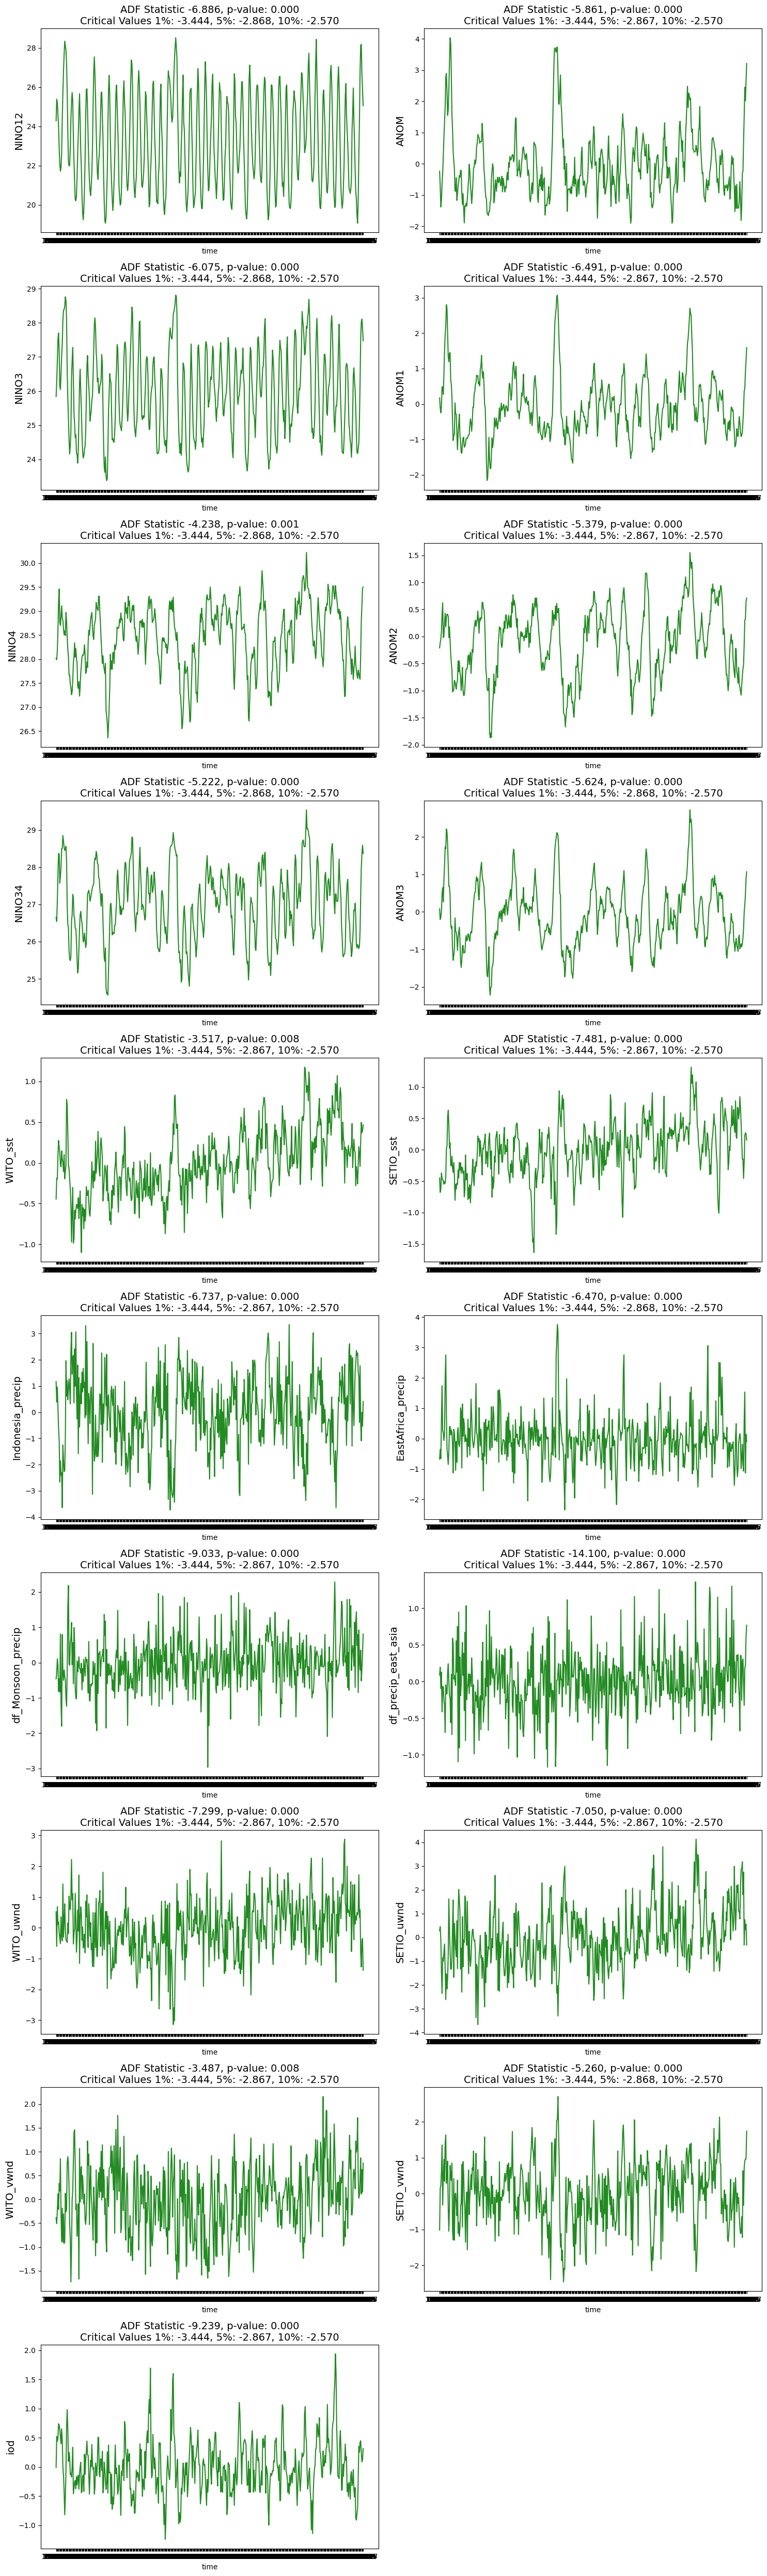

In [ ]:
import seaborn as sns

# ADF 검정 시각화 입니다.
def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=series.index, y=series.values, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

# df_combined의 컬럼 수에 따라 필요한 행과 열의 수를 계산합니다.
nrows = int(np.ceil(len(df_combined.columns) / 2))
ncols = 2

f, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# 각 컬럼에 대해 시각화를 수행합니다.
for idx, column in enumerate(df_combined.columns):
    row_idx = idx // 2
    col_idx = idx % 2
    visualize_adfuller_results(df_combined[column], column, axes[row_idx, col_idx])

# 모든 subplot이 사용되지 않았을 경우, 나머지를 제거합니다.
if len(df_combined.columns) % 2 != 0:
    f.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

ADF 통계량이 크리티컬 값보다 작고 (더 음수인 경우) p-값이 0.05 미만일 경우, 시계열 데이터는 정상성을 가진다고 볼 수 있습니다.
여기서 주어진 모든 시계열 데이터는 p-값이 매우 작으므로 정상성을 갖는 것으로 판단됩니다.


## 시간데이터 가공하기

시간 데이터를 머신러닝이 더 잘 학습할 수 있도록 가공해주도록 하겠습니다.

In [ ]:
# 1. 인덱스를 'time' 칼럼으로 변경
df_combined.reset_index(level=0, inplace=True)
df_combined.rename(columns={'index': 'time'}, inplace=True)

# 2. 'time' 칼럼을 datetime 타입으로 변환
df_combined['time'] = pd.to_datetime(df_combined['time'])

# 3. 변환된 'time' 칼럼을 바탕으로 week_of_year 계산
df_combined['week_of_year'] = (df_combined['time'].dt.dayofyear - 1) // 7 + 1

df_combined['year'] = pd.DatetimeIndex(df_combined['time']).year
df_combined['month'] = pd.DatetimeIndex(df_combined['time']).month
df_combined['quarter'] = pd.DatetimeIndex(df_combined['time']).quarter
df_combined['season'] = df_combined['month'] % 12 // 3 + 1

df_combined[['time', 'year', 'month', 'week_of_year', 'quarter', 'season']].head()


,time,year,month,week_of_year,quarter,season
0,1982-01-01,1982,1,1,1,1
1,1982-02-01,1982,2,5,1,1
2,1982-03-01,1982,3,9,1,2
3,1982-04-01,1982,4,13,2,2
4,1982-05-01,1982,5,18,2,2


In [ ]:
# 변환과정에서 불필요한 칼럼들이 생성되면 삭제해줍니다.
columns_to_drop = ['level_0', 'index']

for col in columns_to_drop:
    if col in df_combined.columns:
        df_combined.drop(columns=[col], inplace=True)

df_combined

,time,NINO12,ANOM,NINO3,ANOM1,NINO4,ANOM2,NINO34,ANOM3,WITO_sst,...,WITO_uwnd,SETIO_uwnd,WITO_vwnd,SETIO_vwnd,iod,week_of_year,year,month,quarter,season
0,1982-01-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,-0.445135,...,0.521092,0.278734,-0.385960,-1.014530,-0.006475,1,1982,1,1,1
1,1982-02-01,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,-0.188154,...,-0.600750,0.449057,-0.510005,0.156598,0.525734,5,1982,2,1,1
2,1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,-0.200312,...,0.680847,-0.100317,-0.226681,0.224568,0.440154,9,1982,3,1,2
3,1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,0.097959,...,0.109704,-1.467557,0.115794,0.629377,0.493691,13,1982,4,2,2
4,1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,0.273335,...,0.187322,-2.355855,-0.212273,1.356591,0.740477,18,1982,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494,2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,0.265505,...,-0.804566,-0.323961,0.869174,0.717196,0.448401,9,2023,3,1,2
495,2023-04-01,28.18,2.45,28.02,0.44,28.81,0.30,27.99,0.19,0.495687,...,-1.270414,0.742720,0.113398,0.908506,0.249823,13,2023,4,2,2
496,2023-05-01,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47,0.369839,...,-0.395972,0.321881,0.626889,0.964782,0.088724,18,2023,5,2,2
497,2023-06-01,25.81,2.63,27.85,1.21,29.48,0.64,28.59,0.88,0.396232,...,-0.343502,0.551518,0.151238,0.965876,0.129093,22,2023,6,2,3


In [ ]:
# month 칼럼을 순환하고 있다는 것을 머신러닝이 더 잘 이해할 수 있도록 주기함수로 바꿔주도록 하겠습니다.
month_in_year = 12
df_combined['month_sin'] = np.sin(2*np.pi*df_combined['month']/month_in_year)
df_combined['month_cos'] = np.cos(2*np.pi*df_combined['month']/month_in_year)
df_combined[['month_cos', 'month_sin']].head()

,month_cos,month_sin
0,8.660254e-01,0.500000
1,5.000000e-01,0.866025
2,6.123234e-17,1.000000
3,-5.000000e-01,0.866025
4,-8.660254e-01,0.500000


## 시계열 분해
시계열에 영향을 주는 일반적인 요인을 시계열에서 분리해 분석하는 기법입니다.

요인으로는 다음과 같습니다.
1. 추세요인(Trend)
2. 계열요인(Seasonal)
3. 순환요인(Cyclical)
4. 불규칙요인(Irregular)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

combined_columns = [
    'NINO12', 'ANOM', 'NINO3', 'ANOM1', 'NINO4', 'ANOM2', 'NINO34',
    'ANOM3', 'WITO_sst', 'SETIO_sst', 'Indonesia_precip', 'df_precip_east_asia',
    'EastAfrica_precip', 'df_Monsoon_precip', 'WITO_uwnd', 'SETIO_uwnd',
    'WITO_vwnd', 'SETIO_vwnd'
]

for column in combined_columns:
    decomp = seasonal_decompose(df_combined[column], period=52, model='additive', extrapolate_trend='freq')
    df_combined[f"{column}_trend"] = decomp.trend
    df_combined[f"{column}_seasonal"] = decomp.seasonal

# df_combined에 새로운 trend와 seasonal columns이 추가됩니다.
# seasonal_decompose에는 순환요인이 추출되지않습니다.

In [ ]:
import math

n_cols = 2
vars_per_col = math.ceil(len(combined_columns) / n_cols)  # 한 열에 그릴 변수 수
n_rows = vars_per_col * 4  # 한 변수당 4개의 그래프 (observed, trend, seasonal, irregular)
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(16, 3 * n_rows))

for i, column in enumerate(combined_columns):
    col_idx = i // vars_per_col
    base_row = (i % vars_per_col) * 4

    res = seasonal_decompose(df_combined[column], period=52, model='additive', extrapolate_trend='freq')

    ax[base_row, col_idx].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[base_row, col_idx], legend=False, color='dodgerblue')
    ax[base_row, col_idx].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[base_row + 1, col_idx], legend=False, color='dodgerblue')
    ax[base_row + 1, col_idx].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[base_row + 2, col_idx], legend=False, color='dodgerblue')
    ax[base_row + 2, col_idx].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[base_row + 3, col_idx], legend=False, color='dodgerblue')
    ax[base_row + 3, col_idx].set_ylabel('Irregular', fontsize=14)

plt.tight_layout()
plt.show()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 534, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1550, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1185, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

## 지연
다른 변수들과의 상관 관계를 비교하기 위해 각 변수를 지연된 상태로 계산합니다.
이 방법을 사용하면 어느 정도 시간 차이가 있어도 비교가 가능합니다.

In [ ]:
weeks_in_month = 4
new_columns = {}

for column in combined_columns:
    new_columns[f'{column}_seasonal_shift_b_2m'] = df_combined[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    new_columns[f'{column}_seasonal_shift_b_1m'] = df_combined[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    new_columns[f'{column}_seasonal_shift_1m'] = df_combined[f'{column}_seasonal'].shift(1 * weeks_in_month)
    new_columns[f'{column}_seasonal_shift_2m'] = df_combined[f'{column}_seasonal'].shift(2 * weeks_in_month)
    new_columns[f'{column}_seasonal_shift_3m'] = df_combined[f'{column}_seasonal'].shift(3 * weeks_in_month)

df_final = pd.concat([df_combined, pd.DataFrame(new_columns)], axis=1)

In [ ]:
df_final.index = pd.to_datetime(df_final['time'])
df_final.drop('time', axis=1, inplace=True)
df_final

,NINO12,ANOM,NINO3,ANOM1,NINO4,ANOM2,NINO34,ANOM3,WITO_sst,SETIO_sst,...,WITO_vwnd_seasonal_shift_b_2m,WITO_vwnd_seasonal_shift_b_1m,WITO_vwnd_seasonal_shift_1m,WITO_vwnd_seasonal_shift_2m,WITO_vwnd_seasonal_shift_3m,SETIO_vwnd_seasonal_shift_b_2m,SETIO_vwnd_seasonal_shift_b_1m,SETIO_vwnd_seasonal_shift_1m,SETIO_vwnd_seasonal_shift_2m,SETIO_vwnd_seasonal_shift_3m
time,,,,,,,,,,,,,,,,,,,,,
1982-01-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,-0.445135,-0.449956,...,-0.001875,0.275155,NaN,NaN,NaN,-0.023410,0.685129,NaN,NaN,NaN
1982-02-01,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,-0.188154,-0.677327,...,-0.251761,0.062095,NaN,NaN,NaN,0.092836,0.082895,NaN,NaN,NaN
1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,-0.200312,-0.621465,...,-0.255153,0.083047,NaN,NaN,NaN,-0.258649,0.044844,NaN,NaN,NaN
1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,0.097959,-0.372171,...,-0.150802,0.181350,NaN,NaN,NaN,-0.003385,0.220626,NaN,NaN,NaN
1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,0.273335,-0.452794,...,-0.067733,-0.001875,0.073361,NaN,NaN,-0.012832,-0.023410,-0.381383,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,0.265505,-0.181684,...,NaN,0.131662,0.052153,0.148029,-0.121086,NaN,-0.129306,-0.218684,-0.018033,0.151417
2023-04-01,28.18,2.45,28.02,0.44,28.81,0.30,27.99,0.19,0.495687,0.225299,...,NaN,NaN,0.077455,0.081001,-0.142868,NaN,NaN,-0.001816,-0.254912,0.012715
2023-05-01,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47,0.369839,0.270541,...,NaN,NaN,-0.208997,-0.056174,-0.151188,NaN,NaN,-0.489190,-0.209128,-0.106826


## EDA
본격적인 EDA를 해보겠습니다.

일단 주기성을 살펴보도록 하겠습니다.

In [ ]:
# _seasonal 이 포함된 열만 선택
selected_seasonal_columns = [col + '_seasonal' for col in combined_columns if col + '_seasonal' in df_final.columns]

fig = go.Figure()

# 선택된 열에 대한 그래프 추가
for col in selected_seasonal_columns:
    trace = go.Scatter(x=df_final.index, y=df_final[col], name=col, visible=False)
    fig.add_trace(trace)

fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="YTD", step="year", stepmode="todate"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)

# 드롭다운 메뉴에 사용할 버튼 생성
buttons = []
for i, col in enumerate(selected_seasonal_columns):
    buttons.append(
        dict(
            label=col,
            method="update",
            args=[{"visible": [i == j for j in range(len(selected_seasonal_columns))]}, {"title": col}],
        )
    )

fig.update_layout(updatemenus=[{"buttons": buttons, "direction": "down", "showactive": True}])

fig.show()

In [ ]:
# 데이터를 로드합니다. 주어진 데이터 파일의 경로를 지정해야 합니다.
df = df_combined  # 데이터프레임을 불러옵니다.

# 'time' 열을 날짜 형식으로 변환합니다.
df['time'] = pd.to_datetime(df['time'])

# 'year' 열을 기준으로 최근 10년 데이터를 선택합니다.
recent_10_years = df[df['year'] >= (df['year'].max() - 9)]

result_data = []
columns = ['Variable', 'Max value (Month)', 'Min value (Month)']

# 'combined_columns' 내에서 '_seasonal'이 포함된 열만 선택
selected_seasonal_columns = [col for col in df.columns if '_seasonal' in col]

# selected_seasonal_columns 항목에 대해 반복하여 월을 찾습니다.
for variable in selected_seasonal_columns:
    max_temp = recent_10_years[recent_10_years[variable] == recent_10_years[variable].max()]
    min_temp = recent_10_years[recent_10_years[variable] == recent_10_years[variable].min()]
    max_month = max_temp['time'].dt.strftime('%B').values[0]
    min_month = min_temp['time'].dt.strftime('%B').values[0]
    result_data.append([variable, max_month, min_month])

# 결과를 데이터프레임으로 변환
result_df = pd.DataFrame(result_data, columns=columns)

# 결과를 출력
result_df

,Variable,Max value (Month),Min value (Month)
0,NINO12_seasonal,October,May
1,ANOM_seasonal,November,May
2,NINO3_seasonal,July,May
3,ANOM1_seasonal,September,May
4,NINO4_seasonal,November,September
5,ANOM2_seasonal,December,May
6,NINO34_seasonal,July,June
7,ANOM3_seasonal,September,June
8,WITO_sst_seasonal,September,July
9,SETIO_sst_seasonal,March,May


###상관도 확인하기

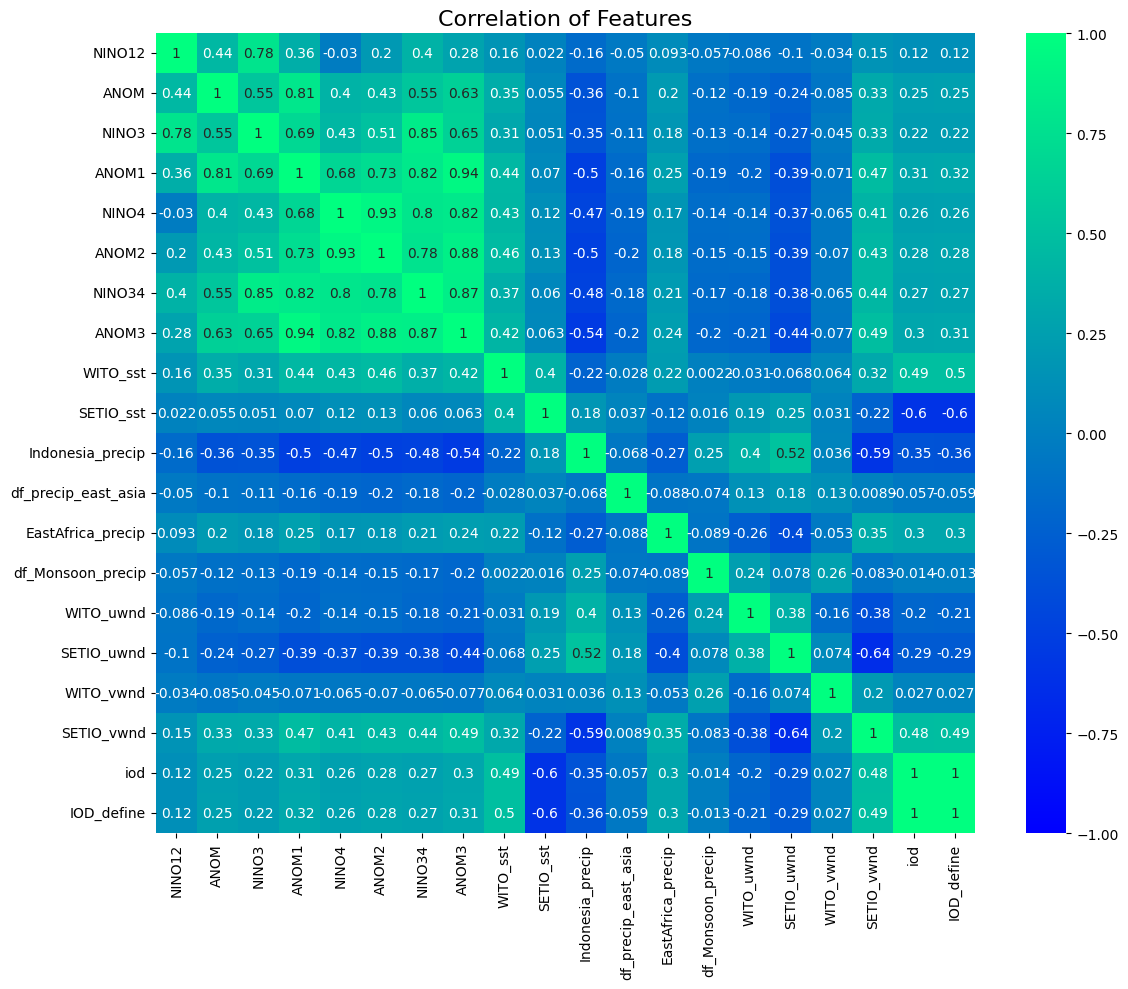

In [ ]:
# 인도양 쌍극자 지수의 정의를 이용해서 칼럼을 하나 만들고 상관관계를 확인해보겠습니다.
df_final['IOD_define'] = df_final['WITO_sst'] - df_final['SETIO_sst']

# 'iod'와 'IOD_define' 추가
for column_name in ['iod', 'IOD_define']:
    if column_name not in combined_columns:
        combined_columns.append(column_name)

# 데이터프레임 복사
df_final_copy = df_final.copy()

# combined_columns에 대한 상관관계 행렬
corrmat_core = df_final_copy[combined_columns].corr()

f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat_core, annot=True, vmin=-1, vmax=1, cmap='winter', ax=ax)
ax.set_title('Correlation of Features', fontsize=16)

plt.tight_layout()
plt.show()

#### **고찰**
상관관계에서 주목해야할 점은
* NINO 지수들이 인도네시아 강수량편차, 몬순 강수량 편차, IOD의 u방향 풍속와 음의 상관관계, WTIO의 sst, iod, SETIO의 v방향 풍속, 동아프리카 강수량 편차, 양의 상관관계에 놓인걸 확인할 수 있습니다.

* WTIO에서의 sst는 인도네시아 강수량편차에는 상관을 끼치지만 다른 지역에는 상관이 적은 것을 확인할 수 있습니다. 또, SETIO v방향 풍속과 양의 상관관계가 있어보입니다.
* SETIO에서는 WTIO보다는 NINO의 영향을 조금 덜 받고 대체적으로 WTIO의 상관과 반대의 성향을 띄고 있습니다.
* 인도네시아 강수량 편차는 IOD 지역의 u방향 풍속과 양의 상관관계에 놓여있고 v방향 풍속과는 음의 상관관계를 가지고있습니다.
* 그리고 저희가 연구하고자 했던 논문의 좌표값인 몬순의 영향을 받는 지역의 강수량편차로 SETIO의 풍속과 상관이 어느 정도 있는 것을 확인할 수 있습니다.
* 마지막으로 저희가 정의로 생성해낸 iod_define 칼럼이 iod와 거의 유사하다고 나오고 있습니다.
이를 feature로 사용하면 매우 좋은 성능이 나올거라고 생각합니다.


### 지연상관도 확인하기
기상은 즉각 상관이 있지않을 수도 있습니다. 시간이 지난 후 상관이 있을 수도 있으므로 지연상관도를 확인해봐야합니다.
지연상관도는 매우 많아서 확인하기 힘드므로 NINO 지수의 대표값인 NINO34만 추출하고 나눠서 확인하도록 하겠습니다.

In [ ]:
df_final_copy.dropna(inplace=True)

In [ ]:
lag_columns = [
    'NINO34', 'WITO_sst', 'SETIO_sst', 'Indonesia_precip', 'df_precip_east_asia',
    'EastAfrica_precip', 'df_Monsoon_precip', 'WITO_uwnd', 'SETIO_uwnd',
    'WITO_vwnd', 'SETIO_vwnd'
]

shift_suffixes = ['', '_shift_b_2m', '_shift_b_1m', '_shift_1m', '_shift_2m', '_shift_3m']

# '_seasonal' 접미사와 '_shift' 접미사를 조합
selected_columns = [col + '_seasonal' + shift_suffix for col in lag_columns for shift_suffix in shift_suffixes if col + '_seasonal' + shift_suffix in df_final_copy.columns]

# 'iod'가 selected_columns에 없는 경우 추가
if 'iod' not in selected_columns:
    selected_columns.append('iod')

# 상관 행렬 계산 (모든 '_seasonal_shift' 조합 및 'iod' 포함)
corrmat = df_final_copy[selected_columns].corr()

# '_seasonal' 접미사가 포함된 항목 및 'iod'를 대상으로 출력
for col in lag_columns + ['iod']:
    if col in lag_columns:
        col_name = col + '_seasonal'  # _seasonal 접미사 추가
    else:
        col_name = col  # 'iod'는 접미사 추가 없이 사용

    print(f"Correlation of {col_name} with other columns (Top 5 & Bottom 5):\n")

    # 자기 자신을 제외한 상관 관계를 가져오기
    correlations = corrmat[col_name].drop(col_name)

    # 상관도가 높은 순서대로 정렬하여 상위 2개 출력
    top_2 = correlations.sort_values(ascending=False).head(3)
    print(top_2)

    # 상관도가 낮은 순서대로 정렬하여 하위 3개 출력
    bottom_3 = correlations.sort_values(ascending=True).head(3)
    print(bottom_3)

    print('-' * 50)

Correlation of NINO34_seasonal with other columns (Top 5 & Bottom 5):

Indonesia_precip_seasonal_shift_3m    0.545190
WITO_sst_seasonal                     0.532988
WITO_sst_seasonal_shift_b_1m          0.516159
Name: NINO34_seasonal, dtype: float64
WITO_uwnd_seasonal                   -0.557848
WITO_sst_seasonal_shift_2m           -0.517951
Indonesia_precip_seasonal_shift_1m   -0.498737
Name: NINO34_seasonal, dtype: float64
--------------------------------------------------
Correlation of WITO_sst_seasonal with other columns (Top 5 & Bottom 5):

NINO34_seasonal                   0.532988
NINO34_seasonal_shift_1m          0.513922
SETIO_uwnd_seasonal_shift_b_2m    0.509192
Name: WITO_sst_seasonal, dtype: float64
SETIO_sst_seasonal_shift_2m   -0.569909
SETIO_uwnd_seasonal           -0.535888
NINO34_seasonal_shift_b_2m    -0.524593
Name: WITO_sst_seasonal, dtype: float64
--------------------------------------------------
Correlation of SETIO_sst_seasonal with other columns (Top 5 & Botto

#### **고찰**
* NINO34_seasonal과 Indonesia_precip_seasonal_shift_3m 사이에는 높은 양의 상관관계(0.545190)가 있습니다. 이는 NINO34_seasonal 값이 증가하면 약 3개월 후의 Indonesia의 강수량이 증가하는 경향을 나타낼 수 있음을 의미합니다.

* SETIO_uwnd_seasonal과 SETIO_vwnd_seasonal 사이에는 매우 높은 음의 상관관계(-0.731187)가 있습니다.

* Indonesia_precip_seasonal과 SETIO_vwnd_seasonal 사이에는 또한 높은 음의 상관관계(-0.669123)가 있습니다. 이는 SETIO 지역의 수직풍 속도가 감소하는 경향이 있을 때 Indonesia의 강수량이 증가할 수 있음을 나타냅니다.

* 하지만 target과 상관이 있는 칼럼이 없으므로 사용 불가능해보입니다.
<br>
<br>

| 대상 변수 | 관련 변수 | 상관 계수 |
|------------|--------------|------------|
| NINO34_seasonal | Indonesia_precip_seasonal_shift_3m | 0.545190 |
| SETIO_uwnd_seasonal | SETIO_vwnd_seasonal | -0.731187 |
| Indonesia_precip_seasonal | SETIO_vwnd_seasonal | -0.669123 |

### 자기상관분석

* ACF 및 PACF 그래프
: 시계열 데이터가 차분을 통해 정상화(stationarized)된 후 ARIMA 모델을 적용하는 다음 단계는 차분된 시계열에서 남아있는 자기상관성을 수정하기 위해 AR(자기회귀) 항이나 MA(이동평균) 항이 필요한지 결정하는 것입니다.

* 자기상관 함수(Autocorrelation Function, ACF): P는 시계열의 이전 기간을 얼마나 지연(lag)해서 사용할 것인지를 나타냅니다. 예를 들어, P가 3이면 자기회귀 부분의 계산에 시계열의 세 이전 기간을 사용합니다. P는 시계열을 예측하기 위해 조정되는 선을 도와줍니다. P는 MA 파라미터와 관련이 있습니다.

* 부분 자기상관 함수(Partial Autocorrelation Function, PACF): D는 ARIMA 모델에서 시계열을 트렌드나 계절성이 없는 정상화된 시계열로 변환하기 위해 차분(differencing)을 사용합니다. D는 시계열이 정상 상태를 얻기 위해 필요한 차분 변환의 횟수를 나타냅니다. D는 AR 파라미터와 관련이 있습니다.

자기상관 그래프는 계절성을 감지하는 데 도움을 줍니다.

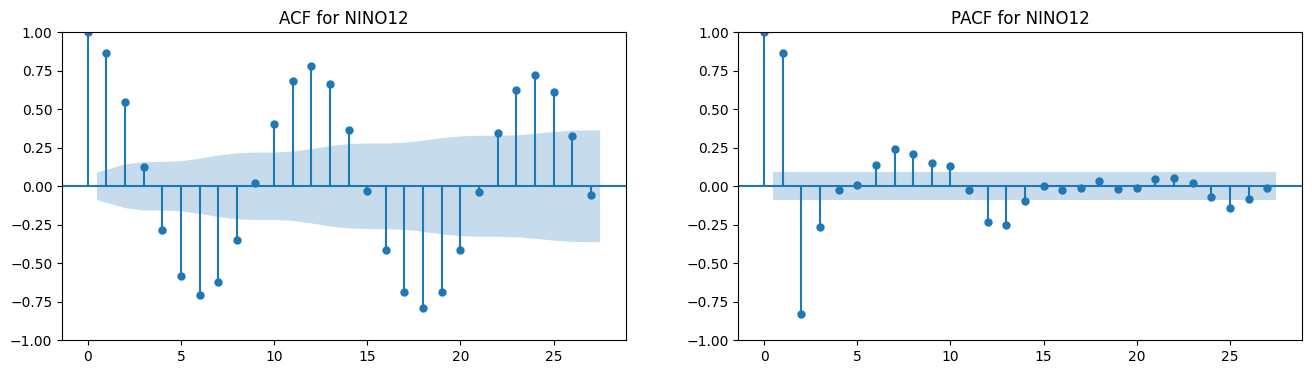

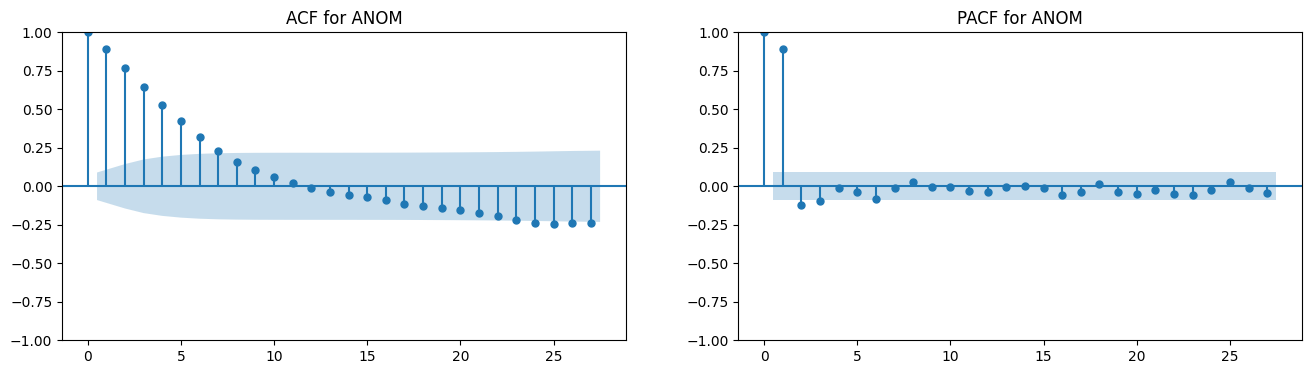

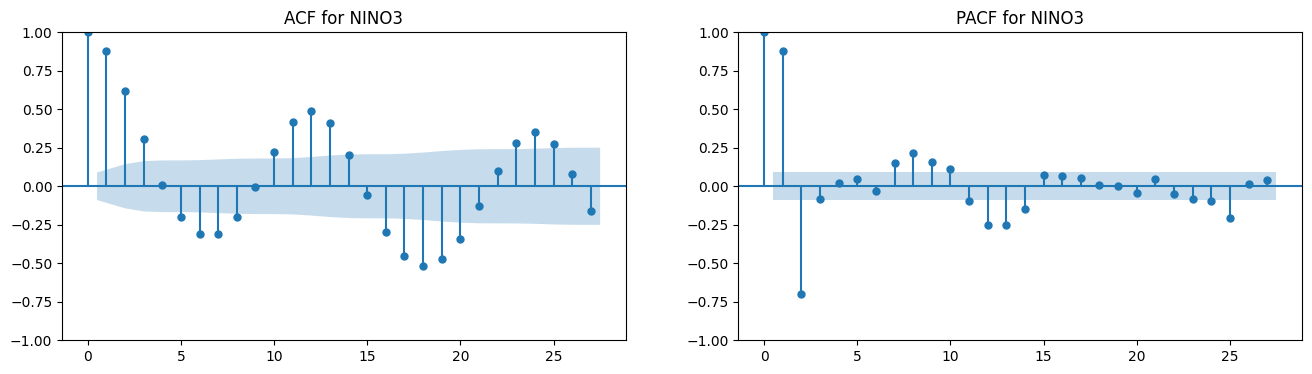

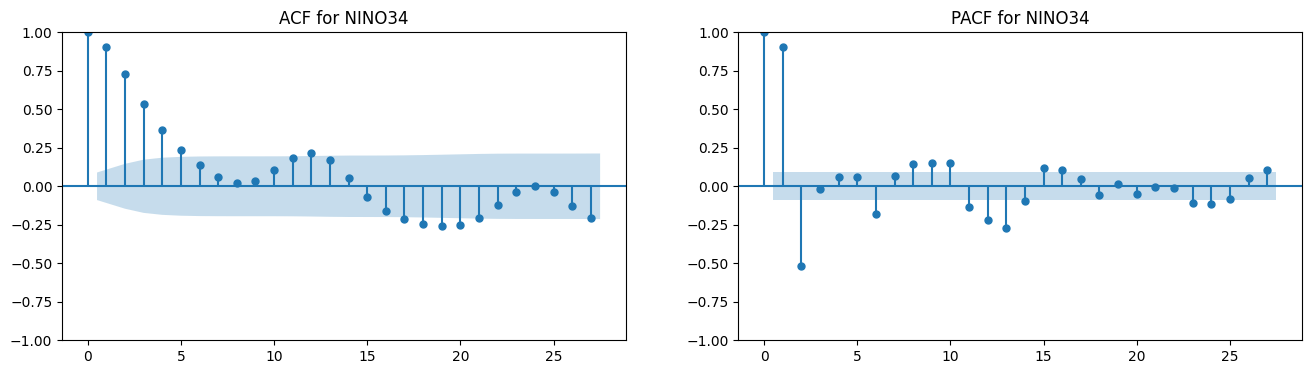

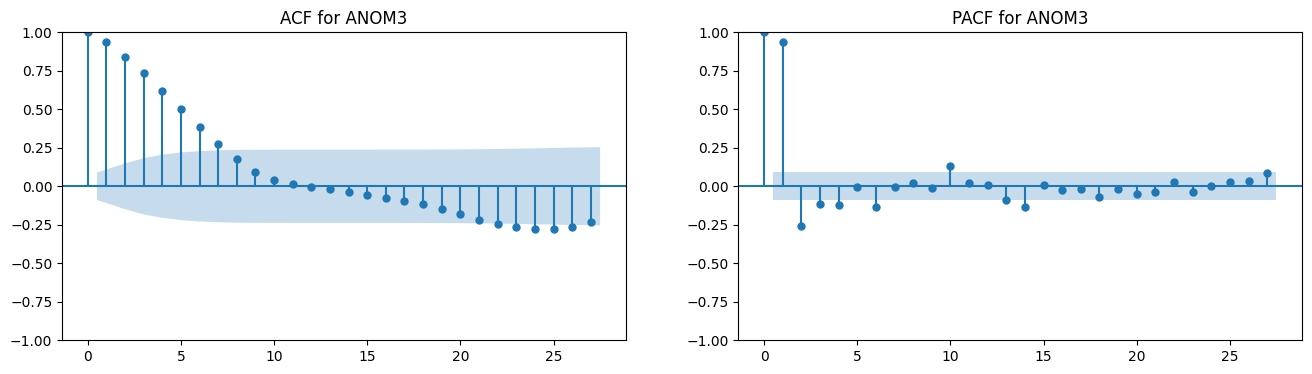

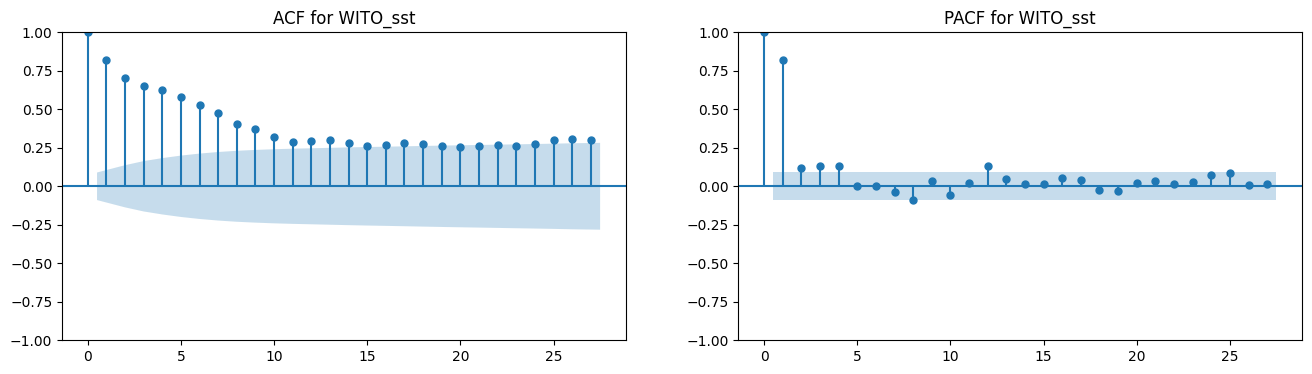

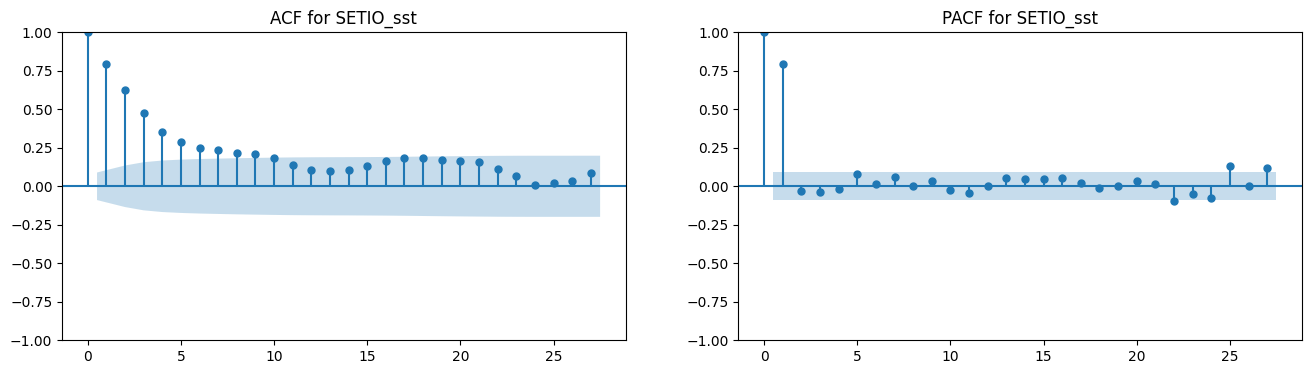

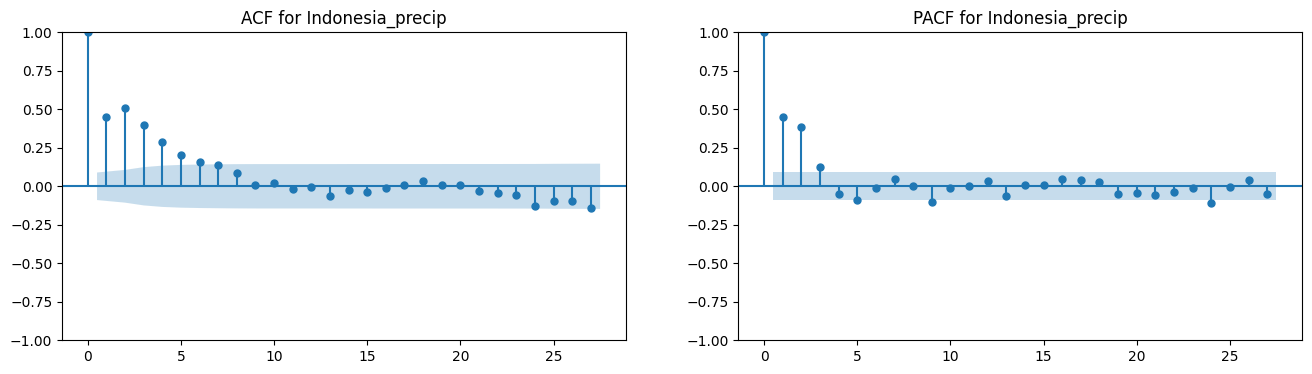

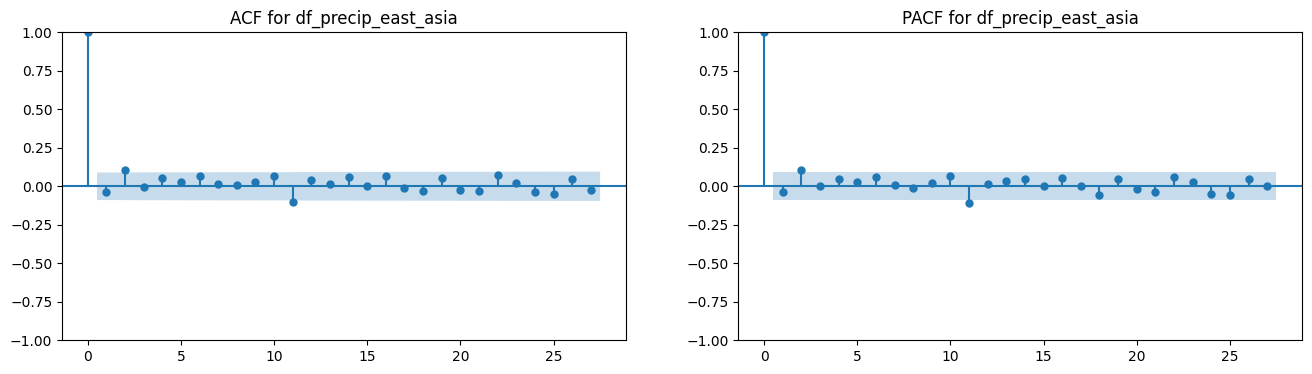

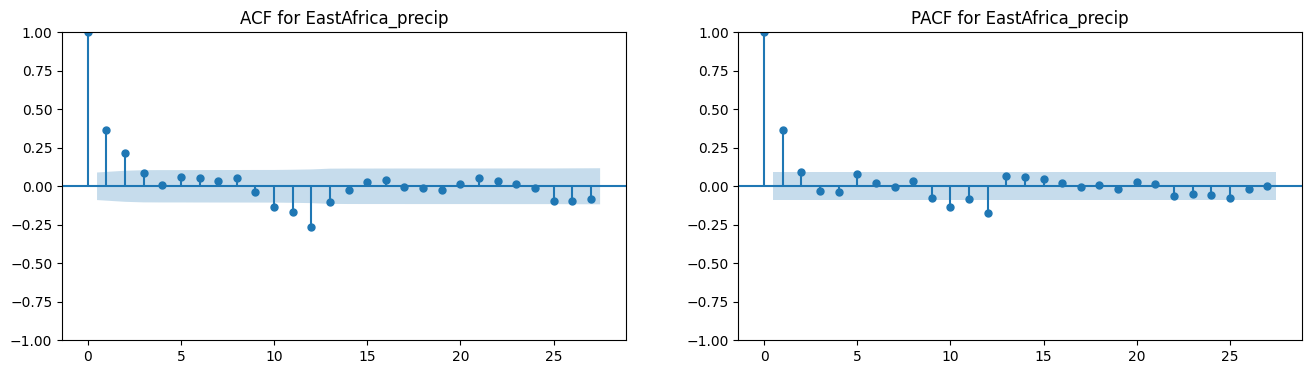

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 534, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1550, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1185, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

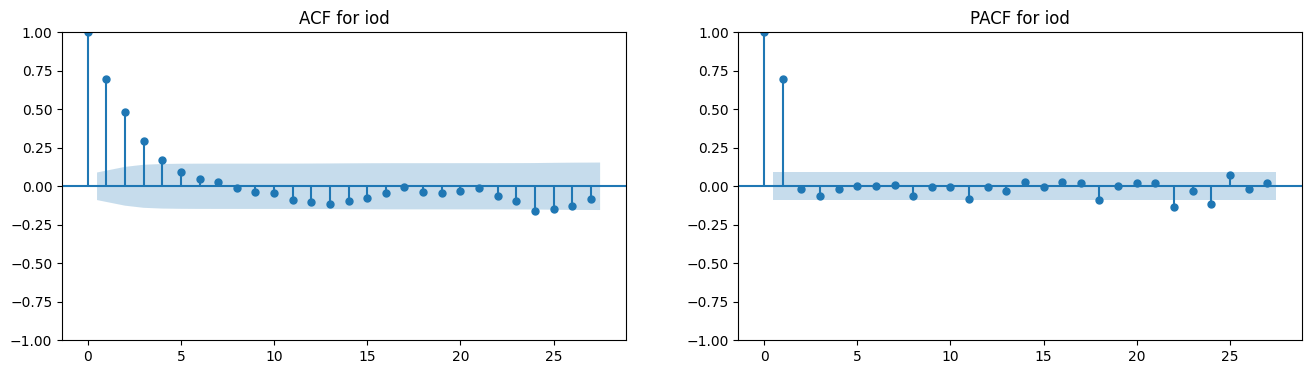

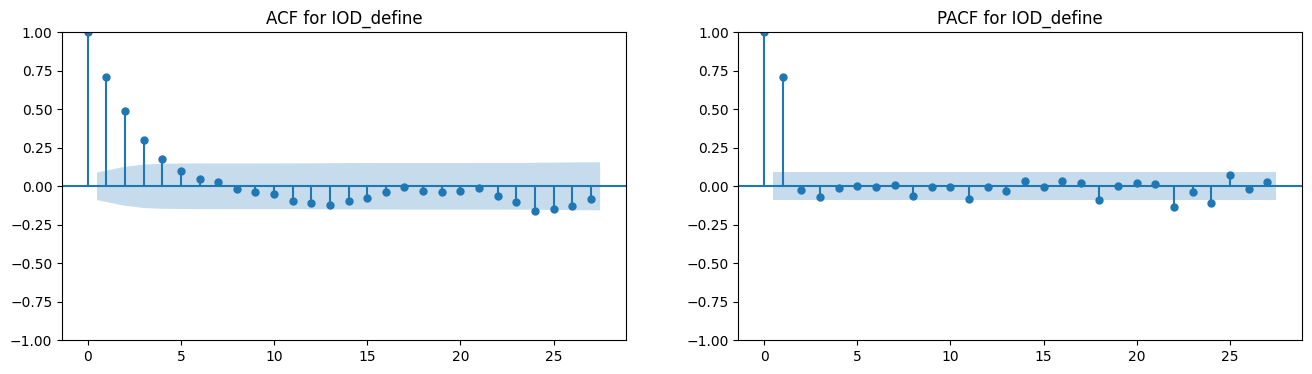

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

for column in combined_columns:
    fig, ax = plt.subplots(1, 2, figsize=(16, 4))

    # ACF plot
    plot_acf(df_final_copy[column].dropna(), ax=ax[0], title=f"ACF for {column}")

    # PACF plot
    plot_pacf(df_final_copy[column].dropna(), ax=ax[1], title=f"PACF for {column}")

    plt.show()

플롯을 해석하는 방법:

* ACF 플롯에서의 지연이 점차적으로 감소하고 PACF에서의 지연이 특정 지점 이후에 급격히 감소하면 AR 모델을 고려해볼 수 있습니다. <br>
* PACF 플롯에서의 지연이 점차적으로 감소하고 ACF에서의 지연이 특정 지점 이후에 급격히 감소하면 MA 모델을 고려해볼 수 있습니다.<br>
<br>
* ACF에서 주기성을 가지면 데이터에 계절성이 있음을 나타낼 수 있습니다. NINO3에서 특히 계절성을 확인할 수 있습니다.
* PACF가 2의 지연에서 급격히 떨어진다면, AR(2) 모델을 고려할 수 있습니다. 다시 말해서, 시계열의 현재 값이 과거 2개의 값에 의존한다는 것을 의미합니다.

## 모델링
EDA 바탕으로 예측모델을 만들어보겠습니다.

In [ ]:
df_final

,NINO12,ANOM,NINO3,ANOM1,NINO4,ANOM2,NINO34,ANOM3,WITO_sst,SETIO_sst,...,WITO_vwnd_seasonal_shift_b_1m,WITO_vwnd_seasonal_shift_1m,WITO_vwnd_seasonal_shift_2m,WITO_vwnd_seasonal_shift_3m,SETIO_vwnd_seasonal_shift_b_2m,SETIO_vwnd_seasonal_shift_b_1m,SETIO_vwnd_seasonal_shift_1m,SETIO_vwnd_seasonal_shift_2m,SETIO_vwnd_seasonal_shift_3m,IOD_define
time,,,,,,,,,,,,,,,,,,,,,
1982-01-01,24.28,-0.24,25.84,0.17,28.01,-0.21,26.65,0.08,-0.445135,-0.449956,...,0.275155,NaN,NaN,NaN,-0.023410,0.685129,NaN,NaN,NaN,0.004821
1982-02-01,25.38,-0.72,26.26,-0.11,27.99,-0.11,26.54,-0.20,-0.188154,-0.677327,...,0.062095,NaN,NaN,NaN,0.092836,0.082895,NaN,NaN,NaN,0.489173
1982-03-01,25.22,-1.38,26.92,-0.25,28.18,-0.05,27.09,-0.14,-0.200312,-0.621465,...,0.083047,NaN,NaN,NaN,-0.258649,0.044844,NaN,NaN,NaN,0.421154
1982-04-01,24.57,-1.16,27.52,-0.05,28.61,0.10,27.83,0.02,0.097959,-0.372171,...,0.181350,NaN,NaN,NaN,-0.003385,0.220626,NaN,NaN,NaN,0.470131
1982-05-01,24.00,-0.62,27.70,0.49,29.19,0.40,28.37,0.49,0.273335,-0.452794,...,-0.001875,0.073361,NaN,NaN,-0.012832,-0.023410,-0.381383,NaN,NaN,0.726129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,28.12,1.52,27.52,0.36,28.09,-0.14,27.23,-0.01,0.265505,-0.181684,...,0.131662,0.052153,0.148029,-0.121086,NaN,-0.129306,-0.218684,-0.018033,0.151417,0.447189
2023-04-01,28.18,2.45,28.02,0.44,28.81,0.30,27.99,0.19,0.495687,0.225299,...,NaN,0.077455,0.081001,-0.142868,NaN,NaN,-0.001816,-0.254912,0.012715,0.270389
2023-05-01,26.63,2.02,28.11,0.90,29.12,0.33,28.35,0.47,0.369839,0.270541,...,NaN,-0.208997,-0.056174,-0.151188,NaN,NaN,-0.489190,-0.209128,-0.106826,0.099298


In [ ]:
# "seasonal"이 포함된 열 제거
df_final = df_final[df_final.columns.drop(list(df_final.filter(regex='seasonal')))]
df_final.columns

Index(['NINO12', 'ANOM', 'NINO3', 'ANOM1', 'NINO4', 'ANOM2', 'NINO34', 'ANOM3',
       'WITO_sst', 'SETIO_sst', 'Indonesia_precip', 'EastAfrica_precip',
       'df_Monsoon_precip', 'df_precip_east_asia', 'WITO_uwnd', 'SETIO_uwnd',
       'WITO_vwnd', 'SETIO_vwnd', 'iod', 'week_of_year', 'year', 'month',
       'quarter', 'season', 'month_sin', 'month_cos', 'NINO12_trend',
       'ANOM_trend', 'NINO3_trend', 'ANOM1_trend', 'NINO4_trend',
       'ANOM2_trend', 'NINO34_trend', 'ANOM3_trend', 'WITO_sst_trend',
       'SETIO_sst_trend', 'Indonesia_precip_trend',
       'df_precip_east_asia_trend', 'EastAfrica_precip_trend',
       'df_Monsoon_precip_trend', 'WITO_uwnd_trend', 'SETIO_uwnd_trend',
       'WITO_vwnd_trend', 'SETIO_vwnd_trend', 'IOD_define'],
      dtype='object')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 제거할 칼럼들을 지정
columns_to_remove = ['NINO12', 'ANOM', 'NINO3', 'ANOM1', 'NINO4', 'ANOM2', 'ANOM3',
                     'NINO12_trend', 'ANOM_trend', 'NINO3_trend', 'ANOM3_trend', 'df_Monsoon_precip_trend',
                     'df_Monsoon_precip', 'WITO_vwnd','WITO_vwnd_trend','ANOM1_trend', 'NINO4_trend', 'ANOM2_trend']

# 제거할 칼럼들을 제외한 나머지 칼럼들로 데이터프레임 업데이트
df_train_1 = df_final.drop(columns=columns_to_remove, axis=1)

In [ ]:
print(df_train_1.columns)

Index(['NINO34', 'WITO_sst', 'SETIO_sst', 'Indonesia_precip',
       'EastAfrica_precip', 'df_precip_east_asia', 'WITO_uwnd', 'SETIO_uwnd',
       'SETIO_vwnd', 'iod', 'week_of_year', 'year', 'month', 'quarter',
       'season', 'month_sin', 'month_cos', 'NINO34_trend', 'WITO_sst_trend',
       'SETIO_sst_trend', 'Indonesia_precip_trend',
       'df_precip_east_asia_trend', 'EastAfrica_precip_trend',
       'WITO_uwnd_trend', 'SETIO_uwnd_trend', 'SETIO_vwnd_trend',
       'IOD_define'],
      dtype='object')


In [ ]:
plt.figure(figsize=(16,6))
plt.title('IOD')
plt.plot(df_train_1['iod'])
plt.xlabel('time', fontsize=18)
plt.ylabel('IOD', fontsize=18)
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


# 1. 특징 선택
features = df_train_1[['iod', 'IOD_define', 'NINO34']]

# 2. 특징 스케일링
scaler = MinMaxScaler(feature_range=(0,1))
scaled_features = scaler.fit_transform(features)

# 3. 훈련 데이터 준비
look_back = 60
training_data_len = int(np.ceil( len(features)))

x_train = []
y_train = []

for i in range(look_back, training_data_len):
    x_train.append(scaled_features[i-look_back:i])
    y_train.append(scaled_features[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2]))

# 4. LSTM 모델 구축
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# 5. 모델 훈련
model.fit(x_train, y_train, batch_size=1, epochs=1)

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/routes.py", line 534, in predict
    output = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 226, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1550, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1185, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    result = con

439/439 [==============================] - 29s 55ms/step - loss: 0.0211


1/1 [==============================] - 0s 163ms/step


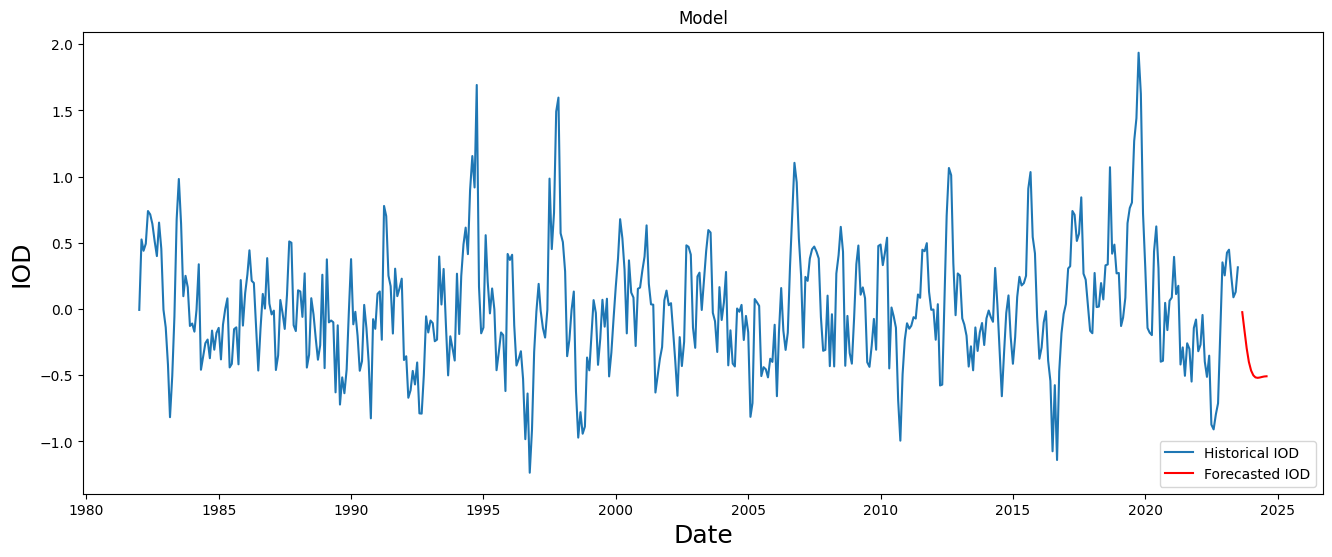

In [ ]:
# 예측할 기간 설정
forecast_period = 12  # 2023년 8월부터 2024년 7월까지 12개월

# 예측
x_forecast = scaled_features[-look_back:].copy()  # 가장 마지막 데이터부터 예측 시작

forecasted_values = []

for i in range(forecast_period):
    x_temp = np.array([x_forecast[-look_back:]])
    pred_value = model.predict(x_temp)

    # 예측값 저장
    forecasted_values.append(pred_value[0][0])

    # 새로운 예측값을 x_forecast에 추가하여 다음 기간 예측 준비
    new_val = [pred_value[0][0], 0, 0]  # 다른 특징들은 0으로 설정 (혹은 필요한 값으로 설정)
    x_forecast = np.vstack((x_forecast, new_val))

forecasted_values = scaler.inverse_transform(np.c_[forecasted_values, np.zeros(forecast_period), np.zeros(forecast_period)])[:,0]

# 시각화
forecast_dates = pd.date_range(start='2023-08-01', periods=forecast_period, freq='M')  # 예측 기간의 날짜 설정
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('IOD', fontsize=18)
plt.plot(df_train_1.index, df_train_1['iod'], label='Historical IOD')
plt.plot(forecast_dates, forecasted_values, label='Forecasted IOD', color='red')
plt.legend(loc='lower right')
plt.show()

## 그라디오 시각화
1. 보고싶은 시간을 칸에 넣어주세요
2. 보고싶은 Zone을 클릭하고 제출하시면 그래프를 보실 수 있습니다.

In [ ]:
import gradio as gr
from mpl_toolkits.basemap import Basemap
import copy

df_precip_east_asia_a = df_precip[
    (df_precip['lat'] >= 10) & (df_precip['lat'] <= 50) &
    (df_precip['lon'] >= 100) & (df_precip['lon'] <= 160)
]
# 인도네시아 강수량 필터링
Indonesia_precip_a = df_precip[
    (df_precip['lon'] >= 95) & (df_precip['lon'] <= 141) &
    (df_precip['lat'] >= -11) & (df_precip['lat'] <= 6)
]

# 동아프리카 강수량 필터링
EastAfrica_precip_a = df_precip[
    (df_precip['lon'] >= 30) & (df_precip['lon'] <= 42) &
    (df_precip['lat'] >= -12) & (df_precip['lat'] <= 5)
]

# 인도 몬순 강수량 필터링
df_Monsoon_a = df_precip[
    (df_precip['lat'] >= 5) & (df_precip['lat'] <= 30) &
    (df_precip['lon'] >= 65) & (df_precip['lon'] <= 95)
]




# 함수 정의 (generate_sst_plot_indian_ocean 및 generate_sst_plot_nino 포함)
def convert_to_year_month(time_values, start_year=0):
    # 시작 시점 설정
    start_date = datetime(start_year, 1, 1)

    # 시간 값을 시작 날짜에 더하여 월과 년으로 변환
    converted_times = [(start_date + timedelta(hours=i)).strftime('%Y-%m') for i in time_values]
    return converted_times

def plot_sst_on_region(df, region_name, m):
    lons = df['lon'].values
    lats = df['lat'].values
    sst = df['sst'].values
    lon, lat = np.meshgrid(np.unique(lons), np.unique(lats))
    sst_grid = sst.reshape(len(np.unique(lats)), len(np.unique(lons)))
    contour = m.contourf(lon, lat, sst_grid, np.arange(-2.5, 3, 0.5), cmap='RdBu_r', extend='both', latlon=True)
    return contour

def generate_sst_plot_indian_ocean(year_month_str):
    time_filter = time_mapping[year_month_str]
    df_filtered_time = df_sst[df_sst['time'] == time_filter]
    df_WITO_sst_a = df_filtered_time[
        (df_filtered_time['lon'] >= 50) & (df_filtered_time['lon'] <= 70) &
        (df_filtered_time['lat'] >= -10) & (df_filtered_time['lat'] <= 10)
    ]
    df_SETIO_sst_a = df_filtered_time[
        (df_filtered_time['lon'] >= 90) & (df_filtered_time['lon'] <= 110) &
        (df_filtered_time['lat'] >= -10) & (df_filtered_time['lat'] <= 0)
    ]

    fig, ax = plt.subplots(figsize=(10, 6))

    m = Basemap(projection='cyl', resolution='l', llcrnrlat=-30, urcrnrlat=30, llcrnrlon=40, urcrnrlon=120, ax=ax)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    contour = plot_sst_on_region(df_WITO_sst_a, 'WITO', m)
    plot_sst_on_region(df_SETIO_sst_a, 'SETIO', m)

    m.plot([50, 70, 70, 50, 50], [-10, -10, 10, 10, -10], color='black', latlon=True)  # WITO
    m.plot([90, 110, 110, 90, 90], [-10, -10, 0, 0, -10], color='black', latlon=True)  # SETIO

    cbar = m.colorbar(contour, location='right', pad="5%")
    cbar.set_label('Sea Surface Temperature (SST)')
    converted_time_filter = convert_to_year_month([time_filter], start_year=1)[0]
    plt.title(f"Sea Surface Temperature (SST) for Time {converted_time_filter}")
    plt.close(fig)  # 그래프를 두 번 표시하는 것을 방지

    return fig

def generate_sst_plot_nino(year_month_str):
    time_filter = time_mapping[year_month_str]
    df_filtered_time = df_sst[df_sst['time'] == time_filter]

    # 각 Niño 지역별 데이터를 필터링
    df_NINO12_sst_a = df_filtered_time[
        (df_filtered_time['lon'] >= 270) & (df_filtered_time['lon'] <= 280) &
        (df_filtered_time['lat'] >= -10) & (df_filtered_time['lat'] <= 0)
    ]

    df_NINO34_sst_a = df_filtered_time[
        (df_filtered_time['lon'] >= 190) & (df_filtered_time['lon'] <= 240) &
        (df_filtered_time['lat'] >= -5) & (df_filtered_time['lat'] <= 5)
    ]

    fig, ax = plt.subplots(figsize=(15, 9))

    # Nino 3.4 지역에 가깝게 지도의 범위를 조절합니다.
    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-30, urcrnrlat=30,
                llcrnrlon=120, urcrnrlon=300, ax=ax)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    # 각 Niño 지역별 SST를 그립니다.
    plot_sst_on_region(df_NINO12_sst_a, 'NINO1+2', m)
    contour = plot_sst_on_region(df_NINO34_sst_a, 'NINO3.4', m)

    # 각 Niño 지역의 경계를 검은색으로 표시
    m.plot([270, 280, 280, 270, 270], [-10, -10, 0, 0, -10], color='black', latlon=True)  # NINO1+2
    m.plot([190, 240, 240, 190, 190], [-5, -5, 5, 5, -5], color='black', latlon=True)  # NINO3.4

    cbar = m.colorbar(contour, location='right', pad="5%")
    cbar.set_label('Sea Surface Temperature (SST)')
    converted_time_filter = convert_to_year_month([time_filter], start_year=1)[0]
    plt.title(f"Sea Surface Temperature (SST) for Time {converted_time_filter}")
    plt.close(fig)

    return fig

######
def generate_precipitation_plot(year_month_str):
    if isinstance(year_month_str, list):
        # year_month_str이 리스트인 경우, 첫 번째 요소를 사용
        year_month_str = year_month_str[0]
    time_filter = time_mapping[year_month_str]
    df_filtered_time = df_precip_east_asia_a[df_precip_east_asia_a['time'] == time_filter]

    fig, ax = plt.subplots(figsize=(15, 9))

    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=5, urcrnrlat=60,
                llcrnrlon=90, urcrnrlon=170, ax=ax)
    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    # 강수량 데이터
    lons = df_filtered_time['lon'].values
    lats = df_filtered_time['lat'].values
    precip = df_filtered_time['precip'].values
    lon, lat = np.meshgrid(np.unique(lons), np.unique(lats))
    precip_grid = precip.reshape(len(np.unique(lats)), len(np.unique(lons)))
    contour = m.contourf(lon, lat, precip_grid, cmap='YlGnBu', extend='both', latlon=True)

    cbar = m.colorbar(contour, location='right', pad="5%")
    cbar.set_label('Precipitation (mm)')
    converted_time_filter = convert_to_year_month([time_filter], start_year=1)[0]
    plt.title(f"East Asia Precipitation Deviation for Time {converted_time_filter}")
    plt.close(fig)  # 그래프를 두 번 표시하는 것을 방지

    return fig

######인도네시아
def generate_Indonesia_precip(year_month_str):
    time_filter = time_mapping[year_month_str]
    df_filtered_time = Indonesia_precip_a[Indonesia_precip_a['time'] == time_filter]

    fig, ax = plt.subplots(figsize=(15, 9))

    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-25, urcrnrlat=16,
                llcrnrlon=85, urcrnrlon=160, ax=ax)

    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    # 강수량 데이터
    lons = df_filtered_time['lon'].values
    lats = df_filtered_time['lat'].values
    precip = df_filtered_time['precip'].values
    lon, lat = np.meshgrid(np.unique(lons), np.unique(lats))
    precip_grid = precip.reshape(len(np.unique(lats)), len(np.unique(lons)))
    contour = m.contourf(lon, lat, precip_grid, cmap='YlGnBu', extend='both', latlon=True)

    cbar = m.colorbar(contour, location='right', pad="5%")
    cbar.set_label('Precipitation (mm)')
    converted_time_filter = convert_to_year_month([time_filter], start_year=1)[0]
    plt.title(f"Indonesia Precipitation Deviation for Time {converted_time_filter}")
    plt.close(fig)  # 그래프를 두 번 표시하는 것을 방지

    return fig
######4

######동아프리카
def generate_EastAfrica_precip(year_month_str):
    time_filter = time_mapping[year_month_str]
    df_filtered_time = EastAfrica_precip_a[EastAfrica_precip_a['time'] == time_filter]

    fig, ax = plt.subplots(figsize=(15, 9))

    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=-29, urcrnrlat=32,
                llcrnrlon=22, urcrnrlon=75, ax=ax)

    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    # 강수량 데이터
    lons = df_filtered_time['lon'].values
    lats = df_filtered_time['lat'].values
    precip = df_filtered_time['precip'].values
    lon, lat = np.meshgrid(np.unique(lons), np.unique(lats))
    precip_grid = precip.reshape(len(np.unique(lats)), len(np.unique(lons)))
    contour = m.contourf(lon, lat, precip_grid, cmap='YlGnBu', extend='both', latlon=True)

    cbar = m.colorbar(contour, location='right', pad="5%")
    cbar.set_label('Precipitation (mm)')
    converted_time_filter = convert_to_year_month([time_filter], start_year=1)[0]
    plt.title(f"EastAfrica Precipitation Deviation for Time {converted_time_filter}")
    plt.close(fig)  # 그래프를 두 번 표시하는 것을 방지

    return fig
######4

######인도 몬순
def generate_df_Monsoon(year_month_str):
    time_filter = time_mapping[year_month_str]
    df_filtered_time = df_Monsoon_a[df_Monsoon_a['time'] == time_filter]

    fig, ax = plt.subplots(figsize=(15, 9))

    m = Basemap(projection='cyl', resolution='l',
                llcrnrlat=1, urcrnrlat=40,
                llcrnrlon=55, urcrnrlon=100, ax=ax)

    m.drawcoastlines()
    m.drawmapboundary()
    m.drawcountries()

    # 강수량 데이터
    lons = df_filtered_time['lon'].values
    lats = df_filtered_time['lat'].values
    precip = df_filtered_time['precip'].values
    lon, lat = np.meshgrid(np.unique(lons), np.unique(lats))
    precip_grid = precip.reshape(len(np.unique(lats)), len(np.unique(lons)))
    contour = m.contourf(lon, lat, precip_grid, cmap='YlGnBu', extend='both', latlon=True)

    cbar = m.colorbar(contour, location='right', pad="5%")
    cbar.set_label('Precipitation (mm)')
    converted_time_filter = convert_to_year_month([time_filter], start_year=1)[0]
    plt.title(f"India Precipitation Deviation for Time {converted_time_filter}")
    plt.close(fig)  # 그래프를 두 번 표시하는 것을 방지

    return fig
######4



###



###



# 공통 데이터 및 함수
unique_times = df_sst['time'].unique()
converted_times_list = convert_to_year_month(unique_times, start_year=1)
time_mapping = dict(zip(converted_times_list, unique_times))

def generate_sst_plot_wrapper(year_month_str, region_selection):
    if region_selection == "IOD":
        return generate_sst_plot_indian_ocean(year_month_str)
    elif region_selection == "NINO":
        return generate_sst_plot_nino(year_month_str)
    elif region_selection == "East_Asia_precip":
        return generate_precipitation_plot(year_month_str)
    elif region_selection == "Indonesia_precip":
        return generate_Indonesia_precip(year_month_str)
    elif region_selection == "EastAfrica_precip":
        return generate_EastAfrica_precip(year_month_str)
    elif region_selection == "df_Monsoon_precip":
        return generate_df_Monsoon(year_month_str)


# Gradio 인터페이스
interface = gr.Interface(fn=generate_sst_plot_wrapper,
                         inputs=[
                             gr.components.Dropdown(choices=time_mapping, label="Select Time"),
                             gr.components.Radio(choices=["IOD", "NINO","Indonesia_precip","East_Asia_precip","EastAfrica_precip","df_Monsoon_precip"], label="Select Region")
                         ],
                         outputs="plot")
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://65c8e19cbc0be3e160.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
